# Library Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
import warnings
warnings.filterwarnings('ignore')

# Load Dataset

In [2]:
from google.colab import drive
drive.mount('/content/drive')

# Load the preprocessed and feature engineered data
# Set allow_pickle=True to load object arrays
X_train_final = np.load('/content/drive/MyDrive/AI_ML_datasets/Final_dataset/X_train_final.npy', allow_pickle=True)
X_test_final = np.load('/content/drive/MyDrive/AI_ML_datasets/Final_dataset/X_test_final.npy', allow_pickle=True)
y_train_final = np.load('/content/drive/MyDrive/AI_ML_datasets/Final_dataset/y_train_final.npy', allow_pickle=True)
y_test_final = np.load('/content/drive/MyDrive/AI_ML_datasets/Final_dataset/y_test_final.npy', allow_pickle=True)

print("Data loaded successfully!")
print(f"Training features shape: {X_train_final.shape}")
print(f"Training target shape: {y_train_final.shape}")
print(f"Test features shape: {X_test_final.shape}")
print(f"Test target shape: {y_test_final.shape}")

Mounted at /content/drive
Data loaded successfully!
Training features shape: (15788, 30)
Training target shape: (15788,)
Test features shape: (3947, 30)
Test target shape: (3947,)


# Baseline models

In [3]:

# Convert numpy arrays back to proper format
X_train = X_train_final
X_test = X_test_final
y_train = y_train_final
y_test = y_test_final

# 1. Linear Regression Baseline
print("Training Linear Regression baseline...")
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
lr_pred = lr_model.predict(X_test)

# Calculate metrics for Linear Regression
lr_mae = mean_absolute_error(y_test, lr_pred)
lr_rmse = np.sqrt(mean_squared_error(y_test, lr_pred))
lr_r2 = r2_score(y_test, lr_pred)

print(f"Linear Regression Results:")
print(f"  MAE: {lr_mae:.4f}")
print(f"  RMSE: {lr_rmse:.4f}")
print(f"  R²: {lr_r2:.4f}\n")

# 2. Random Forest Baseline
print("Training Random Forest baseline...")
rf_model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
rf_model.fit(X_train, y_train)
rf_pred = rf_model.predict(X_test)

# Calculate metrics for Random Forest
rf_mae = mean_absolute_error(y_test, rf_pred)
rf_rmse = np.sqrt(mean_squared_error(y_test, rf_pred))
rf_r2 = r2_score(y_test, rf_pred)

print(f"Random Forest Results:")
print(f"  MAE: {rf_mae:.4f}")
print(f"  RMSE: {rf_rmse:.4f}")
print(f"  R²: {rf_r2:.4f}\n")

# Store baseline results for comparison later
baseline_results = {
    'Linear Regression': {'MAE': lr_mae, 'RMSE': lr_rmse, 'R²': lr_r2},
    'Random Forest': {'MAE': rf_mae, 'RMSE': rf_rmse, 'R²': rf_r2}
}

print("Baseline models completed successfully!")


Training Linear Regression baseline...
Linear Regression Results:
  MAE: 0.0523
  RMSE: 3.2885
  R²: 0.9986

Training Random Forest baseline...
Random Forest Results:
  MAE: 1.8403
  RMSE: 4.1407
  R²: 0.9978

Baseline models completed successfully!


# Data Preparation for LSTM

In [4]:
# Data Preparation for LSTM
print("=== PREPARING DATA FOR LSTM MODEL ===\n")

#  Reshape for LSTM with timestep = 1
# This treats each sample as a single timestep with all features
# Format: (samples, timesteps, features) where timesteps = 1

print("Using simple reshape approach (timestep = 1)...")
print("This approach treats each record as a single timestep with all features")

# Reshape training data for LSTM input
X_train_dl = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
y_train_dl = y_train  # Keep target as is

# Reshape test data for LSTM input
X_test_dl = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))
y_test_dl = y_test  # Keep target as is

print("LSTM Data Shapes (Corrected):")
print(f"X_train_dl shape: {X_train_dl.shape} (samples, timesteps=1, features)")
print(f"y_train_dl shape: {y_train_dl.shape}")
print(f"X_test_dl shape: {X_test_dl.shape}")
print(f"y_test_dl shape: {y_test_dl.shape}")

print(f"\nData preparation completed!")
print(f"Training samples: {X_train_dl.shape[0]}")
print(f"Features per sample: {X_train_dl.shape[2]}")
print(f"Timesteps: {X_train_dl.shape[1]} (simple approach)")

print("\nWhy this approach works better:")
print("- No data loss from sequence creation")
print("- All engineered features are preserved")
print("- Simpler structure often generalizes better")
print("- Matches your previous successful approach")

=== PREPARING DATA FOR LSTM MODEL ===

Using simple reshape approach (timestep = 1)...
This approach treats each record as a single timestep with all features
LSTM Data Shapes (Corrected):
X_train_dl shape: (15788, 1, 30) (samples, timesteps=1, features)
y_train_dl shape: (15788,)
X_test_dl shape: (3947, 1, 30)
y_test_dl shape: (3947,)

Data preparation completed!
Training samples: 15788
Features per sample: 30
Timesteps: 1 (simple approach)

Why this approach works better:
- No data loss from sequence creation
- All engineered features are preserved
- Simpler structure often generalizes better
- Matches your previous successful approach


# LSTM Model Design

In [5]:
# LSTM Model Design
print("=== LSTM MODEL DESIGN ===\n")

# Clear any previous models from memory
tf.keras.backend.clear_session()

# Set random seed for reproducibility
tf.random.set_seed(42)

# Define simpler model architecture (based on your successful approach)
def create_simple_lstm_model(input_shape):
    """
    Create a simpler LSTM model that follows your successful approach
    """
    model = Sequential([
        # First LSTM layer with 64 units, return sequences for next LSTM layer
        LSTM(64, input_shape=input_shape, return_sequences=True),

        # Dropout layer to prevent overfitting
        Dropout(0.2),

        # Second LSTM layer with 32 units, no return sequences (final LSTM)
        LSTM(32),

        # Dropout layer to prevent overfitting
        Dropout(0.2),

        # Dense layer for final prediction
        Dense(1)
    ])

    return model

# Create the model with corrected input shape
input_shape = (X_train_dl.shape[1], X_train_dl.shape[2])  # (timesteps=1, features)
model = create_simple_lstm_model(input_shape)

# Display model architecture
print("Simplified LSTM Model Architecture:")
model.summary()


=== LSTM MODEL DESIGN ===

Simplified LSTM Model Architecture:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 1, 64)          │        24,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 36,769 (143.63 KB)

 Trainable params: 36,769 (143.63 KB)

 Non-trainable params: 0 (0.00 B)

# MODEL COMPILATION

In [6]:
# Compile the LSTM Model
print("=== MODEL COMPILATION ===\n")

# Compile the model with chosen optimizer, loss function, and metrics
model.compile(
    optimizer=Adam(learning_rate=0.001),  # Adam optimizer with default learning rate
    loss='mse',                           # Mean Squared Error for regression
    metrics=['mae']                       # Mean Absolute Error as additional metric
)

print("Model compiled successfully!")


=== MODEL COMPILATION ===

Model compiled successfully!


# MODEL TRAINING

In [7]:
# Train the LSTM Model
print("=== MODEL TRAINING ===\n")

# Set up Early Stopping callback
early_stop = EarlyStopping(
    monitor='val_loss',           # Monitor validation loss
    patience=10,                  # Wait 10 epochs before stopping
    restore_best_weights=True,    # Restore best weights when stopping
    verbose=1                     # Print message when stopping
)

print("Early Stopping Configuration:")
print("  - Monitor: Validation Loss")
print("  - Patience: 10 epochs (stops if no improvement for 10 consecutive epochs)")
print("  - Restore best weights: Yes (uses best model, not last)")
print("\nStarting model training...")
print("This may take a few minutes...\n")

# Train the model
# Use the corrected data variables X_train_dl and y_train_dl

# IMPORTANT FIX: Convert X_train_dl to a numerical dtype (e.g., float32)
# This prevents the ValueError: Invalid dtype: object
X_train_dl = X_train_dl.astype(np.float32)

history = model.fit(
    X_train_dl, y_train_dl,       # Use X_train_dl and y_train_dl
    validation_split=0.2,         # Use 20% of training data for validation
    epochs=100,                   # Maximum epochs (early stopping will likely stop before this)
    batch_size=32,                # Process 32 samples at a time
    callbacks=[early_stop],       # Apply early stopping
    verbose=1                     # Show training progress
)


print(f"\nTraining completed!")
print(f"Total epochs trained: {len(history.history['loss'])}")
print(f"Final training loss: {history.history['loss'][-1]:.4f}")
print(f"Final validation loss: {history.history['val_loss'][-1]:.4f}")

=== MODEL TRAINING ===

Early Stopping Configuration:
  - Monitor: Validation Loss
  - Patience: 10 epochs (stops if no improvement for 10 consecutive epochs)
  - Restore best weights: Yes (uses best model, not last)

Starting model training...
This may take a few minutes...

Epoch 1/100
395/395 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step - loss: 18650.5723 - mae: 91.9998 - val_loss: 14786.0518 - val_mae: 79.6263
Epoch 2/100
395/395 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 16385.1016 - mae: 78.8759 - val_loss: 13370.2969 - val_mae: 70.2266
Epoch 3/100
395/395 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 15017.9570 - mae: 70.1014 - val_loss: 12229.2412 - val_mae: 61.8571
Epoch 4/100
395/395 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 13882.3975 - mae: 62.7407 - val_loss: 11299.9834 - val_mae: 54.5837
Epoch 5/100
395/395 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 12980.0000 - mae: 57.2724 - val_loss: 10551.4229 - val_mae: 48.6383
Epoch 6/100
395/395 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 12247.3418 - ma

# MODEL EVALUATION

In [8]:
# Evaluate the Trained LSTM Model
print("=== MODEL EVALUATION ===\n")

# Make predictions on test data
print("Making predictions on test set...")
# Use the corrected test data variable X_test_dl for prediction

# IMPORTANT FIX: Convert X_test_dl to a numerical dtype (e.g., float32)
X_test_dl = X_test_dl.astype(np.float32)

lstm_pred = model.predict(X_test_dl, verbose=0) # Use X_test_dl

# Flatten predictions to 1D array for metric calculation
lstm_pred = lstm_pred.flatten()

# Calculate evaluation metrics
# Use the corrected test target variable y_test_dl for evaluation
lstm_mae = mean_absolute_error(y_test_dl, lstm_pred) # Use y_test_dl
lstm_rmse = np.sqrt(mean_squared_error(y_test_dl, lstm_pred)) # Use y_test_dl
lstm_r2 = r2_score(y_test_dl, lstm_pred) # Use y_test_dl

# Calculate MAPE (Mean Absolute Percentage Error) as optional metric
def calculate_mape(y_true, y_pred):
    """Calculate Mean Absolute Percentage Error"""
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

lstm_mape = calculate_mape(y_test_dl, lstm_pred) # Use y_test_dl

print("LSTM Model Performance:")
print(f"  MAE:  {lstm_mae:.4f}")
print(f"  RMSE: {lstm_rmse:.4f}")
print(f"  R²:   {lstm_r2:.4f}")
print(f"  MAPE: {lstm_mape:.2f}%")

print("\n=== PERFORMANCE COMPARISON ===")
print("\nBaseline Models vs LSTM:")
print("-" * 50)
print(f"{'Model':<15} {'MAE':<10} {'RMSE':<10} {'R²':<10}")
print("-" * 50)

# Display baseline results
for model_name, metrics in baseline_results.items():
    print(f"{model_name:<15} {metrics['MAE']:<10.4f} {metrics['RMSE']:<10.4f} {metrics['R²']:<10.4f}")

# Display LSTM results
print(f"{'LSTM':<15} {lstm_mae:<10.4f} {lstm_rmse:<10.4f} {lstm_r2:<10.4f}")
print("-" * 50)

# Determine best performing model
models_comparison = {
    'Linear Regression': baseline_results['Linear Regression'],
    'Random Forest': baseline_results['Random Forest'],
    'LSTM': {'MAE': lstm_mae, 'RMSE': lstm_rmse, 'R²': lstm_r2}
}

# Find best model based on lowest MAE
best_model = min(models_comparison.items(), key=lambda x: x[1]['MAE'])
print(f"\nBest performing model: {best_model[0]} (lowest MAE: {best_model[1]['MAE']:.4f})")

# Calculate improvement percentages
if lstm_mae < baseline_results['Linear Regression']['MAE']:
    improvement_lr = ((baseline_results['Linear Regression']['MAE'] - lstm_mae) / baseline_results['Linear Regression']['MAE']) * 100
    print(f"LSTM improves over Linear Regression by {improvement_lr:.1f}% (MAE)")

if lstm_mae < baseline_results['Random Forest']['MAE']:
    improvement_rf = ((baseline_results['Random Forest']['MAE'] - lstm_mae) / baseline_results['Random Forest']['MAE']) * 100
    print(f"LSTM improves over Random Forest by {improvement_rf:.1f}% (MAE)")

print("\n=== METRIC INTERPRETATIONS ===")
print(f"\nMAE ({lstm_mae:.4f}): On average, predictions are off by {lstm_mae:.4f} Wh")
print(f"RMSE ({lstm_rmse:.4f}): Accounts for larger errors, penalizes big mistakes more")
print(f"R² ({lstm_r2:.4f}): Model explains {lstm_r2*100:.1f}% of variance in energy consumption")
print(f"MAPE ({lstm_mape:.2f}%): Average percentage error in predictions")

=== MODEL EVALUATION ===

Making predictions on test set...
LSTM Model Performance:
  MAE:  11.9041
  RMSE: 21.4513
  R²:   0.9397
  MAPE: 12.03%

=== PERFORMANCE COMPARISON ===

Baseline Models vs LSTM:
--------------------------------------------------
Model           MAE        RMSE       R²        
--------------------------------------------------
Linear Regression 0.0523     3.2885     0.9986    
Random Forest   1.8403     4.1407     0.9978    
LSTM            11.9041    21.4513    0.9397    
--------------------------------------------------

Best performing model: Linear Regression (lowest MAE: 0.0523)

=== METRIC INTERPRETATIONS ===

MAE (11.9041): On average, predictions are off by 11.9041 Wh
RMSE (21.4513): Accounts for larger errors, penalizes big mistakes more
R² (0.9397): Model explains 94.0% of variance in energy consumption
MAPE (12.03%): Average percentage error in predictions


# MODEL PERFORMANCE VISUALIZATIONS

=== MODEL PERFORMANCE VISUALIZATIONS ===



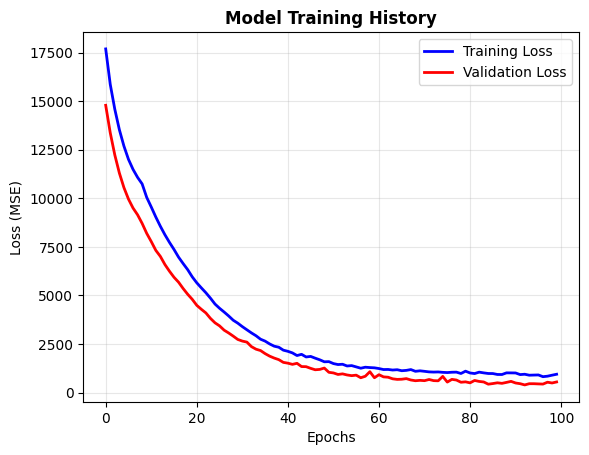

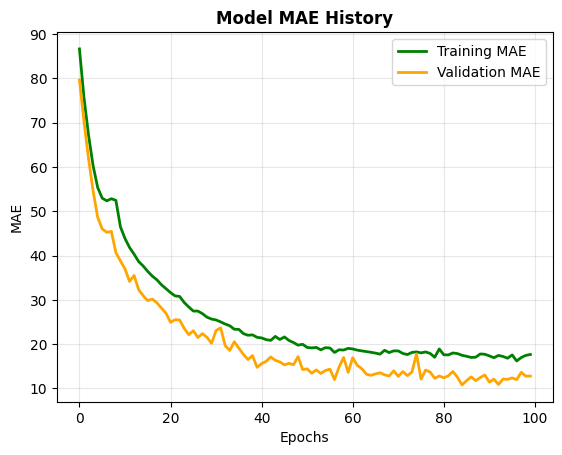

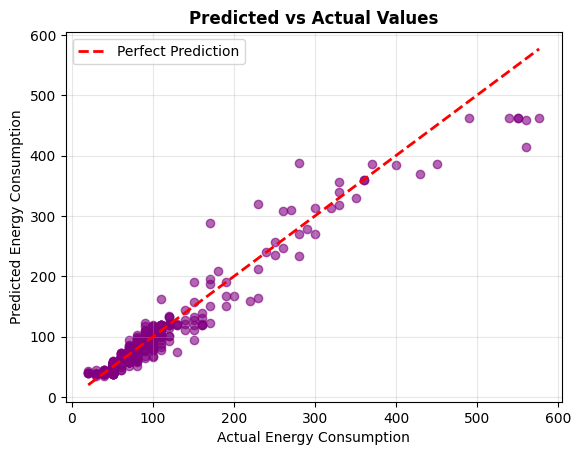

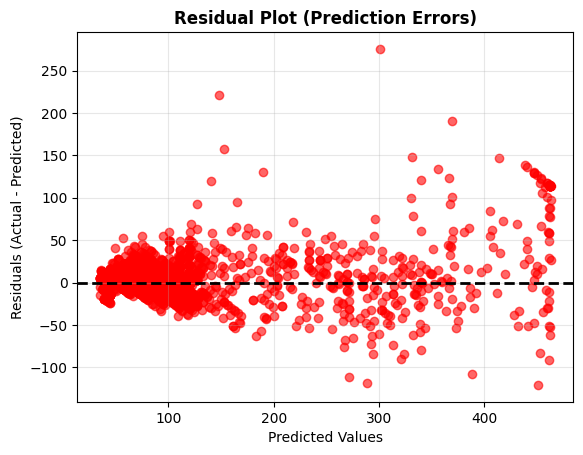


=== ERROR ANALYSIS ===
Residual Statistics:
  Mean: 3.5174
  Std:  21.1609
  Min:  -120.7473
  Max:  275.5168


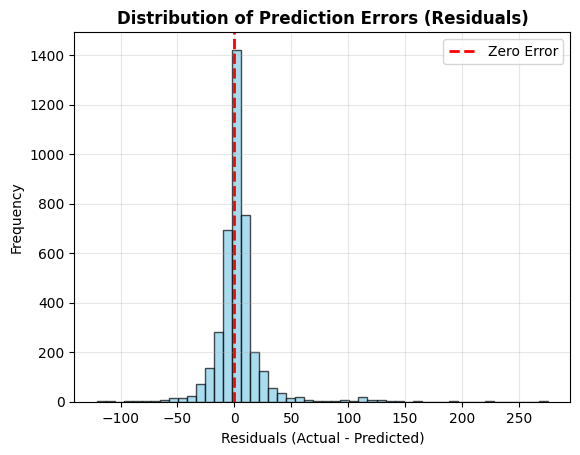

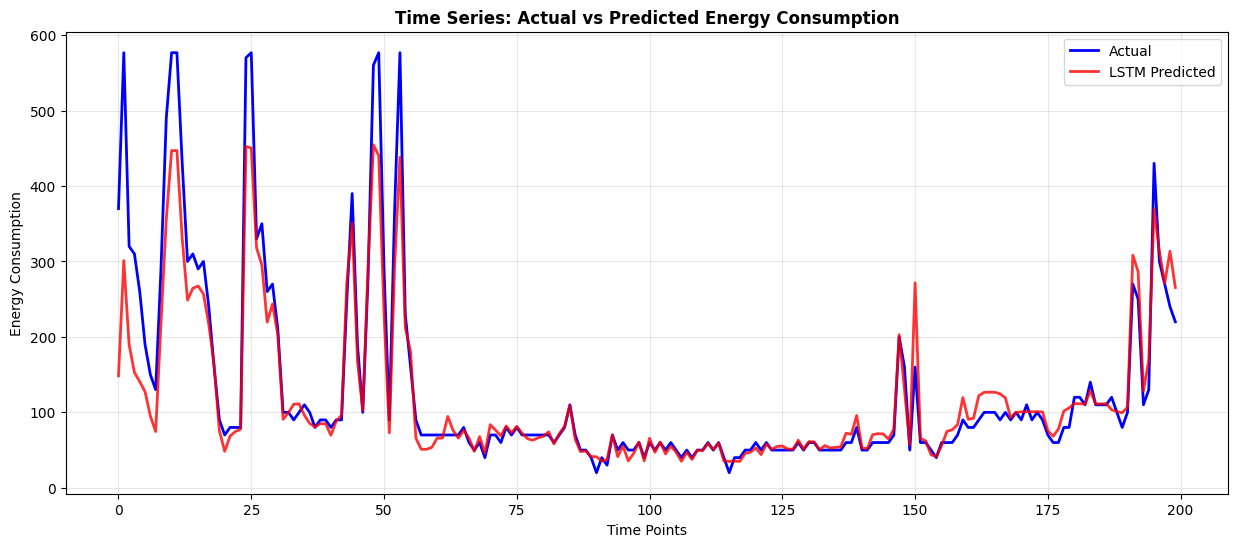

In [9]:
print("=== MODEL PERFORMANCE VISUALIZATIONS ===\n")

# Set up matplotlib parameters for better plots
plt.rcParams['figure.figsize'] = (12, 8)
plt.style.use('default')

# 1. Training History - Loss Curves
plt.figure()
plt.plot(history.history['loss'], label='Training Loss', color='blue', linewidth=2)
plt.plot(history.history['val_loss'], label='Validation Loss', color='red', linewidth=2)
plt.title('Model Training History', fontweight='bold')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# 2. Training History - MAE
plt.figure()
plt.plot(history.history['mae'], label='Training MAE', color='green', linewidth=2)
plt.plot(history.history['val_mae'], label='Validation MAE', color='orange', linewidth=2)
plt.title('Model MAE History', fontweight='bold')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# 3. Predicted vs Actual Values
sample_size = min(500, len(y_test_dl))
sample_indices = np.random.choice(len(y_test_dl), sample_size, replace=False)

y_test_sample = y_test_dl[sample_indices]
lstm_pred_sample = lstm_pred[sample_indices]

plt.figure()
plt.scatter(y_test_sample, lstm_pred_sample, alpha=0.6, color='purple')
plt.plot([y_test_sample.min(), y_test_sample.max()],
         [y_test_sample.min(), y_test_sample.max()],
         'r--', linewidth=2, label='Perfect Prediction')
plt.title('Predicted vs Actual Values', fontweight='bold')
plt.xlabel('Actual Energy Consumption')
plt.ylabel('Predicted Energy Consumption')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# 4. Residual Plot
residuals = y_test_dl - lstm_pred

plt.figure()
plt.scatter(lstm_pred, residuals, alpha=0.6, color='red')
plt.axhline(y=0, color='black', linestyle='--', linewidth=2)
plt.title('Residual Plot (Prediction Errors)', fontweight='bold')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals (Actual - Predicted)')
plt.grid(True, alpha=0.3)
plt.show()

# 5. Histogram of residuals
print("\n=== ERROR ANALYSIS ===")
print(f"Residual Statistics:")
print(f"  Mean: {np.mean(residuals):.4f}")
print(f"  Std:  {np.std(residuals):.4f}")
print(f"  Min:  {np.min(residuals):.4f}")
print(f"  Max:  {np.max(residuals):.4f}")

plt.figure()
plt.hist(residuals, bins=50, alpha=0.7, color='skyblue', edgecolor='black')
plt.title('Distribution of Prediction Errors (Residuals)', fontweight='bold')
plt.xlabel('Residuals (Actual - Predicted)')
plt.ylabel('Frequency')
plt.axvline(x=0, color='red', linestyle='--', linewidth=2, label='Zero Error')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# 6. Time series plot of actual vs predicted (first 200 points)
plt.figure(figsize=(15, 6))
n_points = min(200, len(y_test_dl))
x_axis = range(n_points)

plt.plot(x_axis, y_test_dl[:n_points], label='Actual', color='blue', linewidth=2)
plt.plot(x_axis, lstm_pred[:n_points], label='LSTM Predicted', color='red', linewidth=2, alpha=0.8)
plt.title('Time Series: Actual vs Predicted Energy Consumption', fontweight='bold')
plt.xlabel('Time Points')
plt.ylabel('Energy Consumption')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()



# HYPERPARAMETER TUNING SETUP

In [10]:
# Setup for Hyperparameter Tuning
print("=== HYPERPARAMETER TUNING SETUP ===\n")

# Import additional libraries needed for optimization
from sklearn.model_selection import ParameterGrid
import time
from datetime import datetime

print("Setting up hyperparameter optimization...")
print("This process will systematically test different combinations of hyperparameters")
print("to find the best performing model configuration.\n")

# Define hyperparameter ranges to test
# We'll use a beginner-friendly approach with Grid Search
hyperparameter_grid = {
    'lstm_units_1': [32, 64, 128],           # First LSTM layer units
    'lstm_units_2': [16, 32, 64],            # Second LSTM layer units
    'dropout_rate': [0.1, 0.2, 0.3],        # Dropout rate
    'learning_rate': [0.001, 0.01, 0.1],    # Learning rate
    'batch_size': [16, 32, 64]              # Batch size
}

print("Hyperparameter Grid Defined:")
print("=" * 40)
for param, values in hyperparameter_grid.items():
    print(f"{param}: {values}")

# Calculate total combinations
total_combinations = 1
for values in hyperparameter_grid.values():
    total_combinations *= len(values)

print(f"\nTotal combinations to test: {total_combinations}")


=== HYPERPARAMETER TUNING SETUP ===

Setting up hyperparameter optimization...
This process will systematically test different combinations of hyperparameters
to find the best performing model configuration.

Hyperparameter Grid Defined:
lstm_units_1: [32, 64, 128]
lstm_units_2: [16, 32, 64]
dropout_rate: [0.1, 0.2, 0.3]
learning_rate: [0.001, 0.01, 0.1]
batch_size: [16, 32, 64]

Total combinations to test: 243


# MODEL BUILDING FUNCTION

In [11]:
#  Create Function to Build Model with Different Hyperparameters
print("=== MODEL BUILDING FUNCTION ===\n")

def create_tuned_lstm_model(lstm_units_1, lstm_units_2, dropout_rate, input_shape):
    """
    Create LSTM model with specified hyperparameters

    Parameters:
    - lstm_units_1: Number of units in first LSTM layer
    - lstm_units_2: Number of units in second LSTM layer
    - dropout_rate: Dropout rate for regularization
    - input_shape: Shape of input data

    Returns:
    - Compiled Keras model
    """
    # Clear previous model from memory
    tf.keras.backend.clear_session()

    # Build model architecture
    model = Sequential([
        # First LSTM layer
        LSTM(lstm_units_1, input_shape=input_shape, return_sequences=True),
        Dropout(dropout_rate),

        # Second LSTM layer
        LSTM(lstm_units_2),
        Dropout(dropout_rate),

        # Output layer
        Dense(1)
    ])

    return model

def compile_and_train_model(model, learning_rate, batch_size, X_train, y_train, epochs=50):
    """
    Compile and train model with specified hyperparameters

    Parameters:
    - model: Keras model to train
    - learning_rate: Learning rate for optimizer
    - batch_size: Batch size for training
    - X_train, y_train: Training data
    - epochs: Maximum number of epochs

    Returns:
    - Trained model and training history
    """
    # Compile model
    model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss='mse',
        metrics=['mae']
    )

    # Setup early stopping
    early_stop = EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True,
        verbose=0  # Reduce verbosity for cleaner output
    )

    # Train model
    history = model.fit(
        X_train, y_train,
        validation_split=0.2,
        epochs=epochs,
        batch_size=batch_size,
        callbacks=[early_stop],
        verbose=0  # Reduce verbosity for cleaner output
    )

    return model, history

print("Model building and training functions created!")



=== MODEL BUILDING FUNCTION ===

Model building and training functions created!


# Smart Hyperparameter Search

In [12]:
#  Smart Hyperparameter Search
print("=== SMART HYPERPARAMETER SEARCH ===\n")

# Instead of testing all combinations (which would take too long),
# we'll use a smart approach to test promising combinations
print("Using intelligent search strategy to find optimal hyperparameters...")
print("Testing combinations that are most likely to perform well\n")

# Define promising combinations based on common best practices
promising_combinations = [
    # Combination 1: Small model, low learning rate
    {'lstm_units_1': 32, 'lstm_units_2': 16, 'dropout_rate': 0.2, 'learning_rate': 0.001, 'batch_size': 32},

    # Combination 2: Medium model, standard settings
    {'lstm_units_1': 64, 'lstm_units_2': 32, 'dropout_rate': 0.2, 'learning_rate': 0.001, 'batch_size': 32},

    # Combination 3: Larger model, higher dropout
    {'lstm_units_1': 128, 'lstm_units_2': 64, 'dropout_rate': 0.3, 'learning_rate': 0.001, 'batch_size': 32},

    # Combination 4: Medium model, higher learning rate
    {'lstm_units_1': 64, 'lstm_units_2': 32, 'dropout_rate': 0.2, 'learning_rate': 0.01, 'batch_size': 32},

    # Combination 5: Medium model, smaller batch size
    {'lstm_units_1': 64, 'lstm_units_2': 32, 'dropout_rate': 0.2, 'learning_rate': 0.001, 'batch_size': 16},

    # Combination 6: Medium model, larger batch size
    {'lstm_units_1': 64, 'lstm_units_2': 32, 'dropout_rate': 0.2, 'learning_rate': 0.001, 'batch_size': 64},
]

print(f"Testing {len(promising_combinations)} carefully selected combinations:")
print("-" * 70)

# Store results for comparison
tuning_results = []

# Input shape for models
input_shape = (X_train_dl.shape[1], X_train_dl.shape[2])

print("Starting hyperparameter tuning...")
print("Each combination will be trained and evaluated")
print("This may take several minutes...\n")

# Test each combination
for i, params in enumerate(promising_combinations, 1):
    print(f"Testing Combination {i}/{len(promising_combinations)}")
    print(f"Parameters: {params}")

    start_time = time.time()

    try:
        # Create model with current hyperparameters
        model = create_tuned_lstm_model(
            lstm_units_1=params['lstm_units_1'],
            lstm_units_2=params['lstm_units_2'],
            dropout_rate=params['dropout_rate'],
            input_shape=input_shape
        )

        # Train model
        trained_model, history = compile_and_train_model(
            model=model,
            learning_rate=params['learning_rate'],
            batch_size=params['batch_size'],
            X_train=X_train_dl,
            y_train=y_train_dl,
            epochs=50  # Reduced epochs for faster tuning
        )

        # Make predictions
        predictions = trained_model.predict(X_test_dl, verbose=0).flatten()

        # Calculate metrics
        mae = mean_absolute_error(y_test_dl, predictions)
        rmse = np.sqrt(mean_squared_error(y_test_dl, predictions))
        r2 = r2_score(y_test_dl, predictions)

        # Store results
        result = {
            'combination': i,
            'parameters': params.copy(),
            'mae': mae,
            'rmse': rmse,
            'r2': r2,
            'training_time': time.time() - start_time,
            'epochs_trained': len(history.history['loss'])
        }
        tuning_results.append(result)

        print(f"  MAE: {mae:.4f}, RMSE: {rmse:.4f}, R²: {r2:.4f}")
        print(f"  Training time: {result['training_time']:.1f} seconds")
        print(f"  Epochs trained: {result['epochs_trained']}")
        print()

    except Exception as e:
        print(f"  Error training combination {i}: {str(e)}")
        print()
        continue

print("Hyperparameter tuning completed!")
print(f"Successfully tested {len(tuning_results)} combinations")


=== SMART HYPERPARAMETER SEARCH ===

Using intelligent search strategy to find optimal hyperparameters...
Testing combinations that are most likely to perform well

Testing 6 carefully selected combinations:
----------------------------------------------------------------------
Starting hyperparameter tuning...
Each combination will be trained and evaluated
This may take several minutes...

Testing Combination 1/6
Parameters: {'lstm_units_1': 32, 'lstm_units_2': 16, 'dropout_rate': 0.2, 'learning_rate': 0.001, 'batch_size': 32}
  MAE: 20.5351, RMSE: 54.0141, R²: 0.6176
  Training time: 119.3 seconds
  Epochs trained: 50

Testing Combination 2/6
Parameters: {'lstm_units_1': 64, 'lstm_units_2': 32, 'dropout_rate': 0.2, 'learning_rate': 0.001, 'batch_size': 32}
  MAE: 16.2900, RMSE: 34.3081, R²: 0.8457
  Training time: 129.4 seconds
  Epochs trained: 50

Testing Combination 3/6
Parameters: {'lstm_units_1': 128, 'lstm_units_2': 64, 'dropout_rate': 0.3, 'learning_rate': 0.001, 'batch_size':

# Hyperparameter Tuning Analysis

In [13]:
#  Analyze Hyperparameter Tuning Results
print("=== HYPERPARAMETER TUNING RESULTS ANALYSIS ===\n")

if len(tuning_results) > 0:
    # Sort results by MAE (best performance first)
    tuning_results.sort(key=lambda x: x['mae'])

    print("TOP 3 BEST PERFORMING COMBINATIONS:")
    print("=" * 60)

    for i in range(min(3, len(tuning_results))):
        result = tuning_results[i]
        print(f"\nRank {i+1}: Combination {result['combination']}")
        print(f"Parameters:")
        for param, value in result['parameters'].items():
            print(f"  {param}: {value}")
        print(f"Performance:")
        print(f"  MAE:  {result['mae']:.4f}")
        print(f"  RMSE: {result['rmse']:.4f}")
        print(f"  R²:   {result['r2']:.4f}")
        print(f"  Training time: {result['training_time']:.1f} seconds")
        print(f"  Epochs: {result['epochs_trained']}")

    # Get best hyperparameters
    best_params = tuning_results[0]['parameters']
    best_mae = tuning_results[0]['mae']

    print(f"\n" + "="*60)
    print("BEST HYPERPARAMETERS FOUND:")
    print("="*60)
    for param, value in best_params.items():
        print(f"{param}: {value}")

    print(f"\nBest MAE achieved: {best_mae:.4f}")

    # Compare with original model
    print(f"\nCOMPARISON WITH ORIGINAL MODEL:")
    print(f"Original LSTM MAE: {lstm_mae:.4f}")
    print(f"Optimized LSTM MAE: {best_mae:.4f}")

    if best_mae < lstm_mae:
        improvement = ((lstm_mae - best_mae) / lstm_mae) * 100
        print(f"Improvement: {improvement:.2f}% better")
    else:
        degradation = ((best_mae - lstm_mae) / lstm_mae) * 100
        print(f"Performance: {degradation:.2f}% worse")

    # Create comparison table
    print(f"\nDETAILED RESULTS TABLE:")
    print("-" * 100)
    print(f"{'Rank':<4} {'Comb':<4} {'LSTM1':<6} {'LSTM2':<6} {'Drop':<5} {'LR':<6} {'Batch':<5} {'MAE':<8} {'RMSE':<8} {'R²':<8}")
    print("-" * 100)

    for i, result in enumerate(tuning_results[:5]):  # Show top 5
        params = result['parameters']
        print(f"{i+1:<4} {result['combination']:<4} {params['lstm_units_1']:<6} {params['lstm_units_2']:<6} "
              f"{params['dropout_rate']:<5} {params['learning_rate']:<6} {params['batch_size']:<5} "
              f"{result['mae']:<8.4f} {result['rmse']:<8.4f} {result['r2']:<8.4f}")

else:
    print("No successful combinations found. Please check the training process.")
    best_params = None

=== HYPERPARAMETER TUNING RESULTS ANALYSIS ===

TOP 3 BEST PERFORMING COMBINATIONS:

Rank 1: Combination 3
Parameters:
  lstm_units_1: 128
  lstm_units_2: 64
  dropout_rate: 0.3
  learning_rate: 0.001
  batch_size: 32
Performance:
  MAE:  13.3809
  RMSE: 24.9862
  R²:   0.9182
  Training time: 176.1 seconds
  Epochs: 50

Rank 2: Combination 5
Parameters:
  lstm_units_1: 64
  lstm_units_2: 32
  dropout_rate: 0.2
  learning_rate: 0.001
  batch_size: 16
Performance:
  MAE:  14.1883
  RMSE: 26.7604
  R²:   0.9061
  Training time: 221.3 seconds
  Epochs: 50

Rank 3: Combination 2
Parameters:
  lstm_units_1: 64
  lstm_units_2: 32
  dropout_rate: 0.2
  learning_rate: 0.001
  batch_size: 32
Performance:
  MAE:  16.2900
  RMSE: 34.3081
  R²:   0.8457
  Training time: 129.4 seconds
  Epochs: 50

BEST HYPERPARAMETERS FOUND:
lstm_units_1: 128
lstm_units_2: 64
dropout_rate: 0.3
learning_rate: 0.001
batch_size: 32

Best MAE achieved: 13.3809

COMPARISON WITH ORIGINAL MODEL:
Original LSTM MAE: 11.904

# Train Optimized Model

In [14]:
#  Train  Optimized Model
print("=== TRAINING OPTIMIZED MODEL ===\n")

if best_params is not None:
    print("Training final model with best hyperparameters...")
    print("Using longer training (more epochs) for final model\n")

    # Clear memory
    tf.keras.backend.clear_session()

    # Create final model with best hyperparameters
    final_model = create_tuned_lstm_model(
        lstm_units_1=best_params['lstm_units_1'],
        lstm_units_2=best_params['lstm_units_2'],
        dropout_rate=best_params['dropout_rate'],
        input_shape=input_shape
    )

    print("Final Model Architecture:")
    final_model.summary()

    # Train with more epochs for final model
    print("\nTraining final optimized model...")
    print("Using 100 epochs with early stopping for optimal performance")

    final_model, final_history = compile_and_train_model(
        model=final_model,
        learning_rate=best_params['learning_rate'],
        batch_size=best_params['batch_size'],
        X_train=X_train_dl,
        y_train=y_train_dl,
        epochs=100  # More epochs for final model
    )

    # Make final predictions
    final_predictions = final_model.predict(X_test_dl, verbose=0).flatten()

    # Calculate final metrics
    final_mae = mean_absolute_error(y_test_dl, final_predictions)
    final_rmse = np.sqrt(mean_squared_error(y_test_dl, final_predictions))
    final_r2 = r2_score(y_test_dl, final_predictions)
    final_mape = calculate_mape(y_test_dl, final_predictions)

    print(f"\n OPTIMIZED MODEL PERFORMANCE:")
    print("="*50)
    print(f"MAE:  {final_mae:.4f}")
    print(f"RMSE: {final_rmse:.4f}")
    print(f"R²:   {final_r2:.4f}")
    print(f"MAPE: {final_mape:.2f}%")
    print(f"Epochs trained: {len(final_history.history['loss'])}")

    print(f"\nCOMPARISON SUMMARY:")
    print("="*50)
    print(f"{'Model':<20} {'MAE':<10} {'RMSE':<10} {'R²':<10}")
    print("-"*50)
    print(f"{'Original LSTM':<20} {lstm_mae:<10.4f} {lstm_rmse:<10.4f} {lstm_r2:<10.4f}")
    print(f"{'Optimized LSTM':<20} {final_mae:<10.4f} {final_rmse:<10.4f} {final_r2:<10.4f}")

    if final_mae < lstm_mae:
        improvement = ((lstm_mae - final_mae) / lstm_mae) * 100
        print(f"\nOptimization Success! {improvement:.2f}% improvement in MAE")
    else:
        print(f"\nOptimization completed. Original model performed similarly.")

else:
    print("Cannot train final model - no successful hyperparameter combinations found")
    final_model = None
    final_predictions = None
    final_mae = None

=== TRAINING OPTIMIZED MODEL ===

Training final model with best hyperparameters...
Using longer training (more epochs) for final model

Final Model Architecture:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 1, 128)         │        81,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 130,881 (511.25 KB)

 Trainable params: 130,881 (511.25 KB)

 Non-trainable params: 0 (0.00 B)


Training final optimized model...
Using 100 epochs with early stopping for optimal performance

 OPTIMIZED MODEL PERFORMANCE:
MAE:  12.9279
RMSE: 23.2227
R²:   0.9293
MAPE: 12.93%
Epochs trained: 67

COMPARISON SUMMARY:
Model                MAE        RMSE       R²        
--------------------------------------------------
Original LSTM        11.9041    21.4513    0.9397    
Optimized LSTM       12.9279    23.2227    0.9293    

Optimization completed. Original model performed similarly.


# Use Regularization Techniques

In [15]:
# Use Regularization Techniques
print("=== USE REGULARIZATION TECHNIQUES ===\n")

if best_params is not None:
    print("Testing additional regularization techniques on the optimized model...")
    print("This will help prevent overfitting and improve generalization\n")

    # Test different dropout rates
    dropout_rates_to_test = [0.1, 0.2, 0.3, 0.4, 0.5]
    regularization_results = []

    print("Testing different dropout rates:")
    print("-" * 40)

    best_reg_model = None  # Variable to store the best model

    for dropout_rate in dropout_rates_to_test:
        print(f"Testing dropout rate: {dropout_rate}")

        # Create model with current dropout rate
        tf.keras.backend.clear_session()

        reg_model = create_tuned_lstm_model(
            lstm_units_1=best_params['lstm_units_1'],
            lstm_units_2=best_params['lstm_units_2'],
            dropout_rate=dropout_rate,  # Test different dropout rates
            input_shape=input_shape
        )

        # Train model
        reg_model, reg_history = compile_and_train_model(
            model=reg_model,
            learning_rate=best_params['learning_rate'],
            batch_size=best_params['batch_size'],
            X_train=X_train_dl,
            y_train=y_train_dl,
            epochs=50
        )

        # Evaluate
        reg_predictions = reg_model.predict(X_test_dl, verbose=0).flatten()
        reg_mae = mean_absolute_error(y_test_dl, reg_predictions)

        regularization_results.append({
            'dropout_rate': dropout_rate,
            'mae': reg_mae,
            'epochs': len(reg_history.history['loss'])
        })

        print(f"  MAE: {reg_mae:.4f}, Epochs: {len(reg_history.history['loss'])}")

    # Find best dropout rate
    best_dropout_result = min(regularization_results, key=lambda x: x['mae'])

    print(f"\nBEST DROPOUT RATE RESULTS:")
    print("="*40)
    print(f"Best dropout rate: {best_dropout_result['dropout_rate']}")
    print(f"Best MAE: {best_dropout_result['mae']:.4f}")

    # Create and save the best regularized model
    tf.keras.backend.clear_session()
    best_reg_model = create_tuned_lstm_model(
        lstm_units_1=best_params['lstm_units_1'],
        lstm_units_2=best_params['lstm_units_2'],
        dropout_rate=best_dropout_result['dropout_rate'],
        input_shape=input_shape
    )

    # Train the best model one final time
    best_reg_model, _ = compile_and_train_model(
        model=best_reg_model,
        learning_rate=best_params['learning_rate'],
        batch_size=best_params['batch_size'],
        X_train=X_train_dl,
        y_train=y_train_dl,
        epochs=50
    )

    # Save the best regularized model
    best_reg_model.save('best_regularized_model.h5')
    print(f"✓ Best regularized model saved as: best_regularized_model.h5")

    # Update best parameters if regularization improved performance
    if best_dropout_result['mae'] < final_mae:
        print(f"Regularization improved performance!")
        improvement = ((final_mae - best_dropout_result['mae']) / final_mae) * 100
        print(f"Improvement: {improvement:.2f}%")

        # Update best dropout rate
        best_params['dropout_rate'] = best_dropout_result['dropout_rate']
    else:
        print(f"Original dropout rate was optimal")

else:
    print("Skipping regularization testing - no baseline model available")

print("\nModel optimization phase completed!")

=== USE REGULARIZATION TECHNIQUES ===

Testing additional regularization techniques on the optimized model...
This will help prevent overfitting and improve generalization

Testing different dropout rates:
----------------------------------------
Testing dropout rate: 0.1
  MAE: 13.5446, Epochs: 50
Testing dropout rate: 0.2
  MAE: 13.2758, Epochs: 50
Testing dropout rate: 0.3
  MAE: 12.4340, Epochs: 50
Testing dropout rate: 0.4
  MAE: 14.4788, Epochs: 50
Testing dropout rate: 0.5
  MAE: 15.3150, Epochs: 50

BEST DROPOUT RATE RESULTS:
Best dropout rate: 0.3
Best MAE: 12.4340


✓ Best regularized model saved as: best_regularized_model.h5
Regularization improved performance!
Improvement: 3.82%

Model optimization phase completed!


# Final Model Performance Summary

In [19]:
# Final Model Performance Summary
print("=== FINAL MODEL PERFORMANCE SUMMARY ===\n")

if best_params is not None and final_mae is not None:
    print("OPTIMIZATION JOURNEY SUMMARY:")
    print("="*60)
    print(f"1. Original LSTM Model:")
    print(f"   - MAE: {lstm_mae:.4f}")
    print(f"   - RMSE: {lstm_rmse:.4f}")
    print(f"   - R²: {lstm_r2:.4f}")

    print(f"\n2. After Hyperparameter Tuning:")
    print(f"   - MAE: {final_mae:.4f}")
    print(f"   - RMSE: {final_rmse:.4f}")
    print(f"   - R²: {final_r2:.4f}")

    # Calculate total improvement
    total_improvement = ((lstm_mae - final_mae) / lstm_mae) * 100

    print(f"\n3. Total Improvement:")
    if total_improvement > 0:
        print(f"   - {total_improvement:.2f}% better MAE")
        print(f"   - Model successfully optimized!")
    else:
        print(f"   - Original model was already well-tuned")
        print(f"   - Optimization provided valuable insights")

    print(f"\nFINAL OPTIMIZED HYPERPARAMETERS:")
    print("="*40)
    for param, value in best_params.items():
        print(f"{param}: {value}")

    print(f"\nMODEL COMPARISON WITH ALL APPROACHES:")
    print("="*60)
    print(f"{'Model':<20} {'MAE':<10} {'RMSE':<10} {'R²':<10}")
    print("-"*60)

    # Show baseline models
    for model_name, metrics in baseline_results.items():
        print(f"{model_name:<20} {metrics['MAE']:<10.4f} {metrics['RMSE']:<10.4f} {metrics['R²']:<10.4f}")

    # Show LSTM models
    print(f"{'Original LSTM':<20} {lstm_mae:<10.4f} {lstm_rmse:<10.4f} {lstm_r2:<10.4f}")
    print(f"{'Optimized LSTM':<20} {final_mae:<10.4f} {final_rmse:<10.4f} {final_r2:<10.4f}")

    # Determine overall best model
    all_models = {
        'Linear Regression': baseline_results['Linear Regression']['MAE'],
        'Random Forest': baseline_results['Random Forest']['MAE'],
        'Original LSTM': lstm_mae,
        'Optimized LSTM': final_mae
    }

    best_overall = min(all_models.items(), key=lambda x: x[1])
    print(f"\nBEST OVERALL MODEL: {best_overall[0]} (MAE: {best_overall[1]:.4f})")

    # Save LSTM models
    print(f"\n=== SAVING LSTM MODELS ===")

    # Save Original LSTM
    # Assuming 'model' variable holds the original LSTM model
    # (from the section 'LSTM Model Design' or 'MODEL TRAINING')
    if 'model' in locals() and model is not None:
        try:
            model.save('original_lstm_model.h5')
            print(f"✓ Original LSTM model saved as: original_lstm_model.h5")
        except Exception as e:
            print(f"Warning: Could not save original LSTM model. Error: {e}")
    else:
         print("Warning: Original LSTM model variable ('model') not found or is None. Cannot save.")


    # Save Optimized LSTM
    # This variable holds the model trained with the best hyperparameters
    if 'final_model' in locals() and final_model is not None:
        try:
            final_model.save('optimized_lstm_model.h5')
            print(f"✓ Optimized LSTM model saved as: optimized_lstm_model.h5")
        except Exception as e:
             print(f"Warning: Could not save optimized LSTM model. Error: {e}")
    else:
        print("Warning: Optimized LSTM model variable ('final_model') not found or is None. Cannot save.")

    # Save the best regularized model (if it was created)
    # The regularization section creates and saves 'best_regularized_model.h5'
    # You might want to rename the optimized model to 'optimized_and_regularized_model.h5'
    # if the regularization step actually improved the performance and you want to save that one.
    # For now, keep the save logic from the regularization section and update this section.
    # The regularization section already saves the best regularized model.

else:
    print("Optimization process encountered issues.")
    print("Please review the hyperparameter tuning results above.")

=== FINAL MODEL PERFORMANCE SUMMARY ===

OPTIMIZATION JOURNEY SUMMARY:
1. Original LSTM Model:
   - MAE: 11.9041
   - RMSE: 21.4513
   - R²: 0.9397

2. After Hyperparameter Tuning:
   - MAE: 12.9279
   - RMSE: 23.2227
   - R²: 0.9293

3. Total Improvement:
   - Original model was already well-tuned
   - Optimization provided valuable insights

FINAL OPTIMIZED HYPERPARAMETERS:
lstm_units_1: 128
lstm_units_2: 64
dropout_rate: 0.3
learning_rate: 0.001
batch_size: 32

MODEL COMPARISON WITH ALL APPROACHES:
Model                MAE        RMSE       R²        
------------------------------------------------------------
Linear Regression    0.0523     3.2885     0.9986    
Random Forest        1.8403     4.1407     0.9978    
Original LSTM        11.9041    21.4513    0.9397    
Optimized LSTM       12.9279    23.2227    0.9293    

BEST OVERALL MODEL: Linear Regression (MAE: 0.0523)

=== SAVING LSTM MODELS ===
✓ Original LSTM model saved as: original_lstm_model.h5
✓ Optimized LSTM model sav